# Position-Dependent Weighting in Gensim's FastText
## Introduction

[Mikolov et al. (2017, Section 2.2)][mikolov17advances-sec-2-2] introduced a position-dependent weighting to the context vector computation in the fastText CBOW language model. They reported that this extension has led to **5 point improvement in total accuracy** on the English word analogy task when a larger context window has been used:

> | Model | Semantic | Syntactic | Total |
> |:------|:---------|:----------|:------|
> | cbow + uniq | 79 % | 73 % | 76 % |
> | cbow + uniq + phrases | 82 % | 78 % | 80 % |
> | cbow + uniq + phrases + weighting | 87 % | 82 % | 85 % |


Despite the usefulness of the position-dependent weighting extension, it has [not been implemented to Facebook's fastText yet][facebookresearch/fastText#445].

In this Jupyter notebook, we are going to answer the following four research questions (RQ):

1. Are the results of Mikolov et al. (2017) reproducible in Gensim?
2. Is the improvement in accuracy only the result of larger context window?
3. Can position-dependent weight vectors be replaced with position-dependent scalar weights with no loss of accuracy?
4. Is the speed of position-dependent weight vectors sufficient to be practically useful?

## Methods

The CBOW fastText models use the default parameters described by [Bojanowski et al. (2017, Section 4.3)][bojanowski17enriching] with the exception of the number of negative samples, the sampling threshold, and the window size described by [Mikolov et al. (2017, Section 4)][mikolov17advances-sec-4]. To our knowledge, these parameters are the SOTA on the English word analogy task.

- hash table bucket size $2\times10^6$,
- $300$ vector dimensions,
- negative sampling loss with $10$ negative samples,
- initial learning rate $0.05$,
- sampling threshold $10^{-5}$,
- $n$-gram sizes $\{3, 4, 5, 6\}$, and
- minimum word count $5$,
- window size $15$ with position-dependent weighting and $5$ without position-dependent weighting.

 [bojanowski17enriching]: https://arxiv.org/pdf/1607.04606.pdf#page=4 (Enriching Word Vectors with Subword Information)
 [mikolov17advances-sec-2-2]: https://arxiv.org/pdf/1712.09405.pdf#page=2 (Advances in Pre-Training Distributed Word Representations)
 [mikolov17advances-sec-4]: https://arxiv.org/pdf/1712.09405.pdf#page=3 (Advances in Pre-Training Distributed Word Representations)
 [grave18learning]: https://arxiv.org/pdf/1802.06893.pdf#page=4 (Learning Word Vectors for 157 Languages)
 [facebookresearch/fastText#445]: https://github.com/facebookresearch/fastText/issues/445 (Learn words representation with CBOW plus position-weights)
 [#2698]: https://github.com/RaRe-Technologies/gensim/pull/2698 (KeyedVectors improvements)

In [1]:
FASTTEXT_PARAMETERS = {
    'sg': 0,
    'bucket': 2 * 10**6,
    'negative': 10,
    'alpha': 0.05,
    'min_alpha': 0,
    'sample': 10**-5,
    'min_n': 3,
    'max_n': 6,
    'min_count': 5,
    'workers': 32,
}

To answer **RQ1**, we are going to measure speed and word analogy task accuracies four times:

1. with the `develop` branch (before [#2698][] has been merged),
2. with the `develop` branch (after [#2698][] has been merged),
3. with position-dependent weighting implemented on top of `develop` and switched off, and
4. with position-dependent weighting implemented on top of `develop` and switched on.

The expected scenario is that the first three tests yield the same results with insignificant differences in both accuracy and speed (otherwise, our implementation or [#2698][] are incorrect), and that the fourth test reproduces the accuracies reported by Mikolov et al. with insignificant speed loss.

To answer **RQ2**, we are going to test all configuration with both window size 5 and 15 and compare them in terms of speed and accuracy. To answer **RQ3**, we are going to test both position-dependent weight vectors and position-dependent scalar weights and compare them in terms of speed and accuracy.

To answer **RQ4**, we are going to train fastText without position-dependent weighting for an additional number of epochs that corresponds to the slow-down caused by position-dependent weighting. If fastText without position-dependent weighting can achieve the same of higher accuracy, we will conclude that position-dependent weighting is not practically useful.

 [bojanowski17enriching]: https://arxiv.org/pdf/1607.04606.pdf#page=4 (Enriching Word Vectors with Subword Information)
 [mikolov17advances]: https://arxiv.org/pdf/1712.09405.pdf#page=2 (Advances in Pre-Training Distributed Word Representations)
 [grave18learning]: https://arxiv.org/pdf/1802.06893.pdf#page=4 (Learning Word Vectors for 157 Languages)
 [facebookresearch/fastText#445]: https://github.com/facebookresearch/fastText/issues/445 (Learn words representation with CBOW plus position-weights)
 [#2698]: https://github.com/RaRe-Technologies/gensim/pull/2698 (KeyedVectors improvements)

In [2]:
RARE_URL = 'https://github.com/RaRe-Technologies/gensim.git'
WITIKO_URL = 'https://github.com/Witiko/gensim.git'

BEFORE_2698_REF = '2360459'
AFTER_2698_REF = 'c0e0169'
VECTOR_PDW_REF = 'e03537ce'
SCALAR_PDW_REF = 'bd2596aa'

BEFORE_2698_PARAMETERS = {'iter': 1, 'size': 300}
AFTER_2698_PARAMETERS = {'epochs': 1, 'vector_size': 300}

REPOSITORIES = {
    'Branch develop, before #2698 has been merged': (RARE_URL, BEFORE_2698_REF, BEFORE_2698_PARAMETERS),
    'Branch develop, after #2698 has been merged': (RARE_URL, AFTER_2698_REF, AFTER_2698_PARAMETERS),
    'Branch positional-dependent-scalars': (WITIKO_URL, SCALAR_PDW_REF, AFTER_2698_PARAMETERS),
    'Branch positional-dependent-vectors': (WITIKO_URL, VECTOR_PDW_REF, AFTER_2698_PARAMETERS),
}

CONFIGURATIONS = {
    'CBOW+NS': {},
    'CBOW+NS+PDW': {'position_dependent_weights': 1},
}

VARIANTS = {
    'Window size 5': {'window': 5},
    'Window size 15': {'window': 15},
}

For our experiments, we are using a machine with 252G RAM, 32 Intel Xeon X7560 2.26 GHz CPU cores, and OpenBLAS.

 [#2698]: https://github.com/RaRe-Technologies/gensim/pull/2698 (KeyedVectors improvements)

In [3]:
import numpy as np

np.show_config()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]


### Datasets
For evaluation, we use the English Word Analogy Task first introduced in the [2013 “Distributed Representations of Words and Phrases and their Compositionality” paper by Milolov et al.][distributed]

 [distributed]: https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf

In [4]:
WORD_ANALOGY_DATASET_FILENAME = 'data/word-analogies/questions-words.txt'

In [5]:
%%bash -e -c 'LC_ALL=C bash'
set -e
if ! [ -e data/word-analogies ]
then
    mkdir -p data/word-analogies
    cd data/word-analogies
    wget https://raw.githubusercontent.com/tmikolov/word2vec/master/questions-words.txt
fi

As our dev corpus, we use the 2017 English Wikipedia over 5 epochs.

In [6]:
from itertools import chain

CORPUS_NAME = 'wiki-english-20171001'
CORPUS_NUM_ARTICLES = 4924894

def _read_sentences_helper(article):
    from gensim.utils import simple_preprocess
    all_sentences = []
    for section_title, section_text in zip(article['section_titles'], article['section_texts']):
        sentences = section_text.splitlines()
        sentences = map(str.strip, sentences)
        sentences = (sentence for sentence in sentences if sentence)
        sentences = chain([section_title], sentences)
        sentences = map(simple_preprocess, sentences)
        all_sentences.extend(sentences)
    return all_sentences

class CorpusSentenceIterator(object):
    """Reads tokenized sentences from a downloaded Wikipedia corpus.

    Parameters
    ----------
    language : str
        The language of the Wikipedia corpus.

    """
    def __init__(self):
        self.iterable = None

    def __iter__(self):
        self.__init__()
        return self

    def _read_sentences(self, percentage=1.0):
        assert CURRENT_GENSIM_URL_AND_REF is not None  # _reinstall_gensim has been called prior to importing gensim
        import gensim.downloader
        from tqdm import tqdm
        num_articles = int(CORPUS_NUM_ARTICLES * percentage)
        articles = gensim.downloader.load(CORPUS_NAME)
        articles = (article for article, _ in zip(articles, range(num_articles)))
        articles = tqdm(articles, desc='Reading articles from the {} corpus'.format(CORPUS_NAME), total=num_articles)
        from multiprocessing import Pool
        with Pool(None) as pool:
            for sentences in pool.imap_unordered(_read_sentences_helper, articles):
                for sentence in sentences:
                    yield sentence            

    def __next__(self):
        if self.iterable is None:
            self.iterable = self._read_sentences()
        corpus_sentence = next(self.iterable)
        return corpus_sentence

## Results

In [7]:
CURRENT_GENSIM_URL_AND_REF = None

from itertools import product

def _reinstall_gensim(url, ref):
    global CURRENT_GENSIM_URL_AND_REF
    if CURRENT_GENSIM_URL_AND_REF == (url, ref):
        return  # only reinstall when necessary
    ! pip uninstall gensim -y
    ! cd /var/tmp && \
      rm -rf gensim && \
      git clone {url} && \
      cd gensim && \
      git checkout {ref} && \
      TMPDIR=/var/tmp pip install . && \
      python setup.py build_ext --inplace && \
      python -c 'from gensim.models import FastText' && \
      cd .. && \
      rm -rf gensim
    from sys import modules
    if 'gensim' in modules:
        raise RuntimeError('Restart the kernel and rerun the Jupyter notebook')
    import gensim.downloader
    gensim.downloader.load(CORPUS_NAME)
    CURRENT_GENSIM_URL_AND_REF = (url, ref)

def _stringify_parameters(parameters):
    parameters = sorted(parameters.items())
    import re
    def stringify(obj): return re.sub('_', '-', str(obj))
    parameters = ('{}={}'.format(stringify(key), stringify(value)) for key, value in parameters if key != 'url')
    parameters = '_'.join(parameters)
    return parameters

def _train(fasttext_model_filename, fasttext_parameters, only_load=False):
    training_duration_filename = '{}.duration'.format(fasttext_model_filename)
    try:
        with open(training_duration_filename, 'rt') as f:
            training_duration = float(f.read())
    except IOError as e:
        if only_load:
            raise e
        from datetime import datetime
        assert CURRENT_GENSIM_URL_AND_REF is not None  # # _reinstall_gensim has been called prior to importing gensim
        from gensim.models.fasttext import FastText
        training_start_time = datetime.now()
        corpus_sentences = CorpusSentenceIterator()
        fasttext_model = FastText(corpus_sentences, **fasttext_parameters)
        training_finish_time = datetime.now()
        training_duration = (training_finish_time - training_start_time).total_seconds()
        ! mkdir -p data/models
        fasttext_model.save(fasttext_model_filename)
        with open(training_duration_filename, 'wt') as f:
            print(training_duration, file=f)
    hours = int(training_duration // 3600)
    minutes = int((training_duration % 3600) // 60)
    seconds = int(round((training_duration % 60)))
    training_duration = '{:2d}h {:02d}m {:02d}s'.format(hours, minutes, seconds)
    return training_duration

def _evaluate(fasttext_model_filename, word_analogy_dataset_filename, only_load=False):
    word_analogy_accuracy_filename = '{}.accuracy'.format(fasttext_model_filename)
    try:
        with open(word_analogy_accuracy_filename, 'rt') as f:
            word_analogy_accuracy = float(f.read())
    except IOError:
        if only_load:
            raise e
        assert CURRENT_GENSIM_URL_AND_REF is not None  # # _reinstall_gensim has been called prior to importing gensim
        from gensim.models.fasttext import FastText
        fasttext_model = FastText.load(fasttext_model_filename)
        def evaluate(*args, **kwargs): return fasttext_model.wv.evaluate_word_analogies(*args, **kwargs)
        word_analogy_accuracy, _ = evaluate(word_analogy_dataset_filename, restrict_vocab=200000)
        with open(word_analogy_accuracy_filename, 'wt') as f:
            print(word_analogy_accuracy, file=f)
    word_analogy_accuracy = '{:.2f}%'.format(100.0 * word_analogy_accuracy)
    return word_analogy_accuracy

def _train_fasttext_model(install_parameters, fasttext_parameters, fasttext_model_filename):
    train_parameters = (fasttext_model_filename, fasttext_parameters)
    evaluate_parameters = (fasttext_model_filename, WORD_ANALOGY_DATASET_FILENAME)
    
    try:
        training_duration = _train(*train_parameters, only_load=True)
    except IOError:
        _reinstall_gensim(**install_parameters)
        training_duration = _train(*train_parameters)
        word_analogy_accuracy = _evaluate(*evaluate_parameters)
    else:
        try:
            word_analogy_accuracy = _evaluate(*evaluate_parameters, only_load=True)
        except IOError:
            _reinstall_gensim(**install_parameters)
            word_analogy_accuracy = _evaluate(*evaluate_parameters)
    
    return (training_duration, word_analogy_accuracy)

def _plot_positional_weights(install_parameters, fasttext_parameters, fasttext_model_filename):
    vector_filename = '{}.vectors_positions.npy'.format(fasttext_model_filename)
    try:
        vectors = np.load(vector_filename)
    except IOError:
        _reinstall_gensim(**install_parameters)
        from gensim.models.fasttext import FastText
        fasttext_model = FastText.load(fasttext_model_filename)
        vectors = fasttext_model.wv.vectors_positions
        np.save(vector_filename, vectors)

    if len(vectors.shape) == 1:
        _plot_positional_scalar_weights(vectors)
    else:
        _plot_positional_weight_vectors(vectors)

def _plot_positional_scalar_weights(vectors):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(15, 4))
    ax = plt.axes()
    X = np.arange(vectors.shape[0]) + 1
    Y = vectors
    ax.plot(X, Y)
    ax.grid()
    ax.set_title('Positional scalar weights')
    ax.set_xlim(1, vectors.shape[0])
    ax.set_xlabel('position')
    ax.set_ylabel('weight')

def _plot_positional_weight_vectors(vectors):
    from mpl_toolkits import mplot3d
    import matplotlib.pyplot as plt
    from matplotlib import cm
    fig = plt.figure(figsize=(30, 15))
    ax = plt.axes(projection='3d')
    X, Y = np.arange(vectors.shape[0]) + 1, np.arange(vectors.shape[1]) + 1
    X, Y = np.meshgrid(X, Y)
    Z = vectors[X - 1, Y - 1]
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_title('Positional weight vectors')
    ax.set_xlim(1, vectors.shape[0])
    ax.set_ylim(1, vectors.shape[1])
    ax.set_xlabel('position')
    ax.set_ylabel('feature')
    ax.set_zlabel('weight')

def _resolve_text_specification(repository, configuration, variant, **call_fasttext_parameters):
    configuration_fasttext_parameters = CONFIGURATIONS[configuration]
    url, ref, repository_fasttext_parameters = REPOSITORIES[repository]
    variant_fasttext_parameters = VARIANTS[variant]
    fasttext_parameters = {
        **FASTTEXT_PARAMETERS,
        **configuration_fasttext_parameters,
        **repository_fasttext_parameters,
        **variant_fasttext_parameters,
        **call_fasttext_parameters,
    }
    install_parameters = {'url': url, 'ref': ref}
    parameter_string = _stringify_parameters({**fasttext_parameters, **install_parameters})
    fasttext_model_filename = 'data/models/fasttext-model_{}'.format(parameter_string)
    return (install_parameters, fasttext_parameters, fasttext_model_filename)

def plot_positional_weights(*args, **kwargs):
    _plot_positional_weights(*_resolve_text_specification(*args, **kwargs))

def train_fasttext_model(*args, **kwargs):
    training_duration, word_analogy_accuracy = _train_fasttext_model(*_resolve_text_specification(*args, **kwargs))
    print('Training duration: {}'.format(training_duration))
    print('English word analogy task, total accuracy: {}'.format(word_analogy_accuracy))

def _plot_results(result_number):
    import pandas as pd
    from IPython.display import display, HTML
    tuples = list(product(REPOSITORIES, CONFIGURATIONS, VARIANTS))
    filtered_tuples = []
    results = []
    for args in tuples:
        repository, configuration, variant = args
        if 'Branch develop' in repository and '+PDW' in configuration:
            continue
        filtered_tuples.append(args)
        result = _train_fasttext_model(*_resolve_text_specification(*args))[result_number]
        results.append(result)
    index = pd.MultiIndex.from_tuples(filtered_tuples, names=['repository', 'configuration', 'variant'])
    df = pd.Series(results, index=index).unstack(level=2)
    df = df[VARIANTS]
    df = df.T[REPOSITORIES].T
    display(HTML(df.T.to_html()))

def plot_durations():
    _plot_results(0)

def plot_accuracies():
    _plot_results(1)

### Training Speed and Accuracies
Below are the training durations of the fastText models:

In [10]:
plot_durations()

Below are the English word analogy task total accuracies of the resulting word vectors:

In [11]:
plot_accuracies()

Columns one, two, three and five from the left are a successful sanity check: both accuracy and speed seem comparable between branch `develop` before and after #2698, and with our implementations of the position-dependent weight vectors and positional-dependent scalar weights when position-dependent weighting is switched off. The sixth column shows that our implementation of position-dependent weight vectors is correct, since it leads to a 5 point improvement in accuracy as reported in [the 2017 “Advances in Pre-Training Distributed Word Representations” paper by Mikolov et al.][mikolov17advances]. This gives a positive answer to **RQ1**: The results of Mikolov et al. (2017) are reproducible.

Without positional weight vectors, using window size 15 consistently decreases the accuracy compared to window size 5. With positional weight vectors, accuracy is still improved by ca 3% when using window size 5. This gives a negative answer to **RQ2**: The improvement in accuracy is not only due to the larger context window.

Using positional scalar weights does not seem to improve the accuracy. This gives a negative answer to **RQ3**: position-dependent scalar weights cannot substitute position-dependent weight vectors.

Training without positional weight vectors for three epochs outperforms training with positional weight vectors for one epoch:

 [mikolov17advances]: https://arxiv.org/pdf/1712.09405.pdf (Advances in Pre-Training Distributed Word Representations)

In [8]:
train_fasttext_model('Branch positional-dependent-vectors', 'CBOW+NS+PDW', 'Window size 15')

Training duration:  4h 59m 27s
English word analogy task, total accuracy: 71.01%


In [17]:
train_fasttext_model('Branch positional-dependent-vectors', 'CBOW+NS', 'Window size 5', epochs=3)

Training duration:  4h 34m 36s
English word analogy task, total accuracy: 71.04%


This gives a negative answer to **RQ4**: position-dependent weighting is not practically useful.

### Positional Scalar Weights and Weight Vectors

In [12]:
%matplotlib inline

Below is a plot of the trained positional scalar weights:

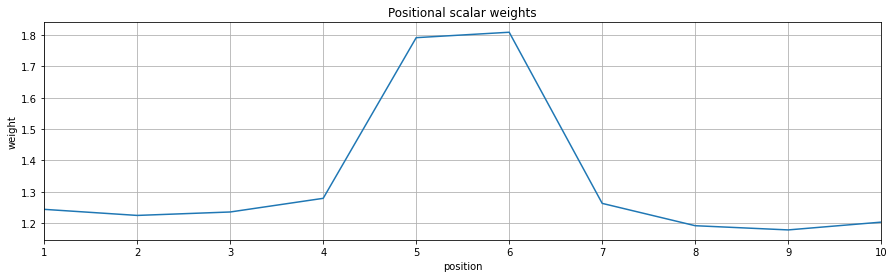

In [13]:
plot_positional_weights('Branch positional-dependent-scalars', 'CBOW+NS+PDW', 'Window size 5')

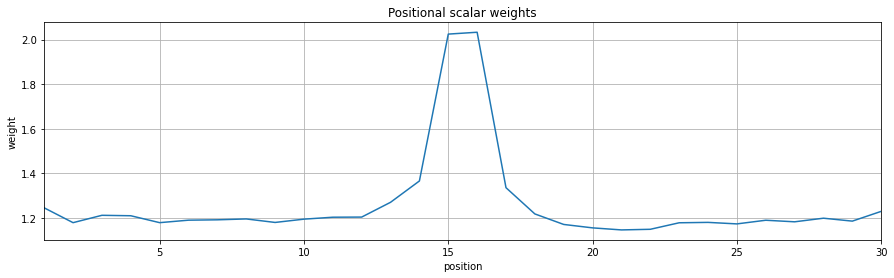

In [14]:
plot_positional_weights('Branch positional-dependent-scalars', 'CBOW+NS+PDW', 'Window size 15')

Below is a plot of the trained positional weight vectors:

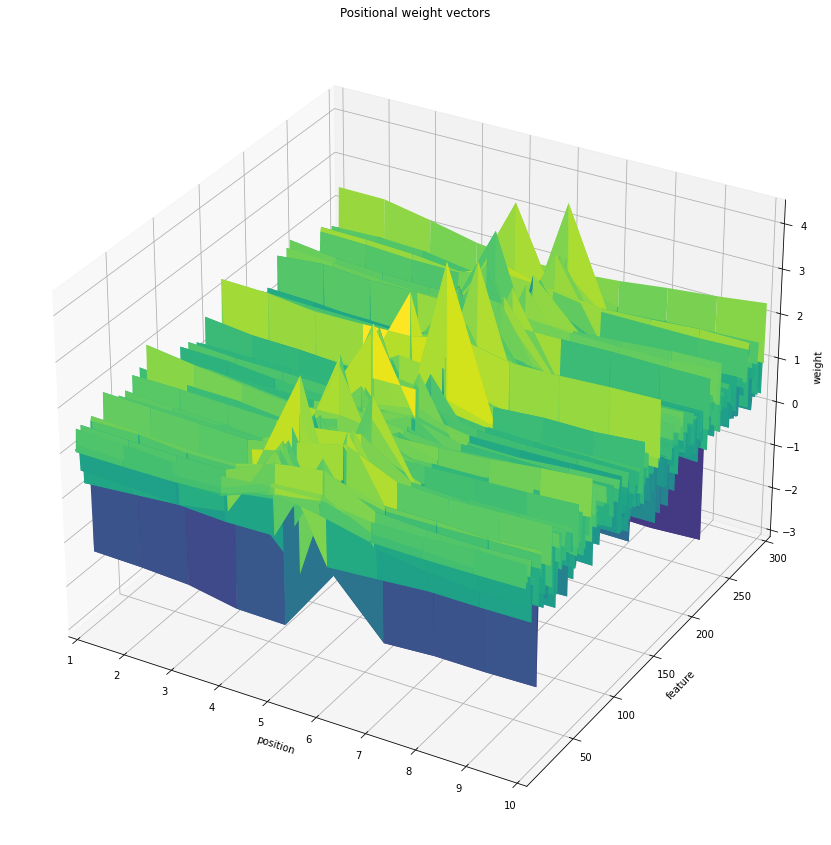

In [15]:
plot_positional_weights('Branch positional-dependent-vectors', 'CBOW+NS+PDW', 'Window size 5')

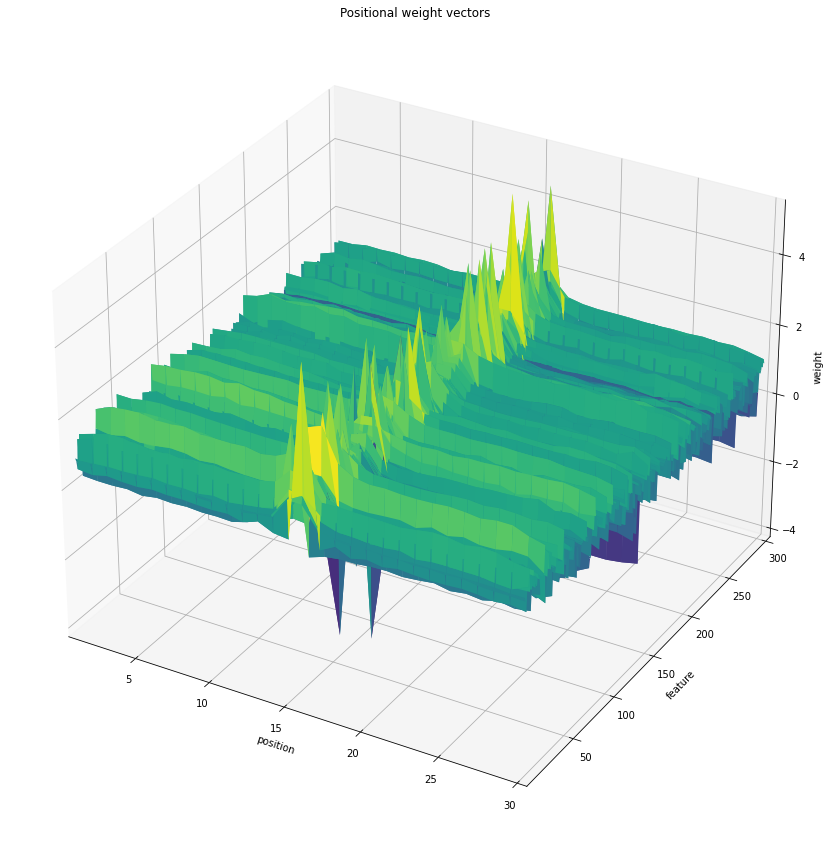

In [16]:
plot_positional_weights('Branch positional-dependent-vectors', 'CBOW+NS+PDW', 'Window size 15')

As expected, the magnitude of both positional scalar weights and positional weight vectors increases around the center word, placing more emphasis at short-term dependencies.